In [1]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import image
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import pandas as pd
from sklearn.model_selection import train_test_split
import copy
import cv2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
#loading file
file_path = "pairsteam.csv"
df = pd.read_csv(file_path, sep=",", header=None)
df.columns = ['Path', 'Identity']
photos_loc = "C:/Users/Dominika/team/"
df['Path'] = photos_loc + df['Path']

In [5]:
X_train, X_test = train_test_split(df, test_size=0.33, random_state=42)

In [6]:
pic_size = 224
#reading image
def get_image_array(path):
    
    image_string = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_string)
    image = tf.image.convert_image_dtype(image, tf.float32)
    #image = tf.image.resize(image, [pic_size, pic_size])
    #image = image/255.0
    return image

def pair_identities(input_df):
    #finding identities with <2 paths
    df_ids = input_df
    identity_counts = df_ids.groupby(['Identity'])
    df_ids['count'] = df_ids.groupby('Identity').transform('count')
    df_ids = df_ids.drop_duplicates(subset = ["Identity"])
    filter = df_ids["count"]<2
    df_ids = df_ids.where(filter)
    df_ids = df_ids.dropna()
    bad_ids = df_ids["Identity"].values.tolist()
    bad_ids = [int(v) for v in bad_ids]
    return bad_ids
    
def ids_dict(df_data):
    dict_ids = {}
    for x in range(len(df_data)):
        id = df_data.iloc[x, 1]
        if id not in dict_ids:
            dict_ids[id] = []
        dict_ids[id].append(df_data.iloc[x, 0])
    return dict_ids

In [7]:
train_bad_ids = pair_identities(X_train)
test_bad_ids = pair_identities(X_test)

train_list = ids_dict(X_train)
test_list = ids_dict(X_test)


In [8]:
def create_triplets(data, bad_ids, count):
    triplets = []
    for i in range(count):
        path_list = copy.deepcopy(data)
        ids = list(path_list.keys())
        #removing ids from the bad_ids list
        ids_for_same = [i for i in ids if i not in bad_ids]
        identity = random.choice(ids_for_same)
        reference_path = random.choice(data.get(identity))
        #removing reference_path to avoid two same paths
        path_list[identity].remove(reference_path)
        same_path = random.choice(path_list.get(identity))
        #removing identity 
        ids.remove(identity)
        diff_identity = random.choice(ids)
        diff_path = random.choice(path_list.get(diff_identity))
        triplets.append([get_image_array(reference_path), get_image_array(same_path), get_image_array(diff_path)])
    return np.array(triplets)

In [9]:
no = 20
X_train = create_triplets(train_list, train_bad_ids, int(no*0.67))
X_test = create_triplets(test_list, test_bad_ids, int(no*0.33))

In [10]:
import os
os.environ["TFHUB_CACHE_DIR"] = "C:/Users/Dominika/"
hub_extractor = "https://tfhub.dev/google/bit/m-r50x1/1"


In [11]:
feature_extractor_layer = hub.KerasLayer(
    hub_extractor,
    input_shape=(pic_size, pic_size, 3),
    trainable=False)


In [12]:
def initialize_base_network():
    input = Input(shape=(pic_size,pic_size,3,))
    x = feature_extractor_layer(input)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    return Model(inputs=input, outputs=x)

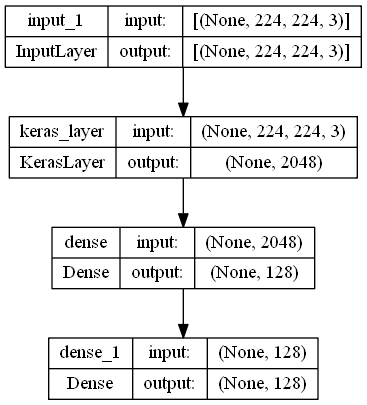

In [13]:
embedding = initialize_base_network()
tf.keras.utils.plot_model(embedding, show_shapes=True)

In [14]:
class SiameseNet(tf.keras.layers.Layer):
    # set the backbone model in constructor
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, feat):
        # get feature vectors from anchor
        feats = self.model(feat[0])
        # from positive image
        pfeats = self.model(feat[1])
        # and from negative image
        nfeats = self.model(feat[2])
        # concatenate vectors to a matrix
        result = tf.stack([feats, pfeats, nfeats])
        return result

In [15]:
class TripletLoss(tf.keras.layers.Layer):
    # margin is settable hyperparameter in constructor
    def __init__(self, margin):
        self.margin = margin
        super().__init__()
        
    # function calculating distance between features
    def distance(self, x, y):
        sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
        return tf.sqrt(tf.maximum(sum_square, K.epsilon()))
    

    def call(self, features):
        # get anchor-positive distance
        pos = self.distance(features[0], features[1])
        # anchor-negative distance
        neg = self.distance(features[0], features[2])
        # difference between anchor positive and anchor negative distances
        loss = pos - neg
        # get overall loss
        return tf.maximum(loss + self.margin, 0.0)

In [16]:
def identity_loss(y_true, y_pred):
    return tf.reduce_mean(y_pred)

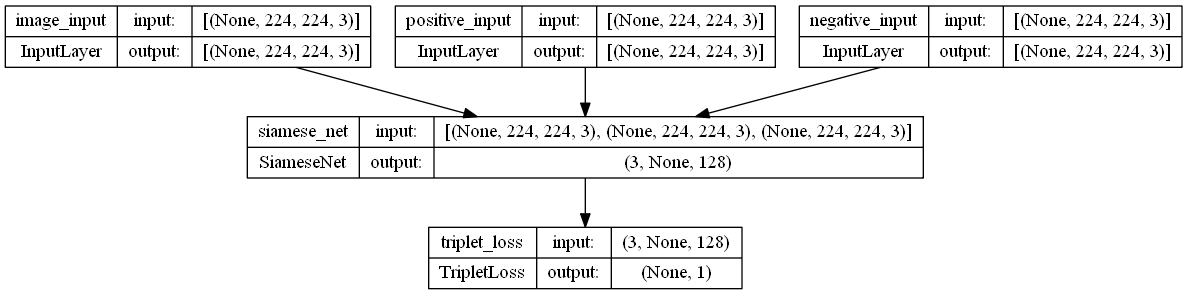

In [17]:
# anchor branch
image_input = Input(shape=(pic_size,pic_size,3), name='image_input')
# positive image branch
positive_input = Input(shape=(pic_size,pic_size,3), name='positive_input')
# negative image branch
negative_input = Input(shape=(pic_size,pic_size,3), name='negative_input')

siamese = SiameseNet(embedding)([image_input, positive_input, negative_input])
loss = TripletLoss(margin=1.0)(siamese)
model = Model(inputs=[image_input, positive_input, negative_input], outputs=loss)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = identity_loss)
tf.keras.utils.plot_model(model, show_shapes=True)

In [18]:
# we don't need labels, everything is handled inside triplet loss layer, so we just set labels to 1, they will not be used anyway
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)
history = model.fit([X_train[:,0], X_train[:,1], X_train[:,2]], np.ones(X_train.shape[0]), batch_size=8, verbose=1, validation_data=([X_test[:,0], X_test[:,1], X_test[:,2]], np.ones(X_test.shape[0])), epochs=20)

Epoch 1/20
2/2 [==============================] - 32s 7s/step - loss: 0.4039 - val_loss: 0.0000e+00
Epoch 2/20
2/2 [==============================] - 7s 4s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20
2/2 [==============================] - 6s 4s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/20
2/2 [==============================] - 6s 4s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20
2/2 [==============================] - 6s 4s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/20
2/2 [==============================] - 6s 4s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/20
2/2 [==============================] - 6s 4s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/20
2/2 [==============================] - 7s 4s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/20
2/2 [==============================] - 6s 4s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/20
2/2 [==============================] - 6s 4s/step - loss: 0.0000

In [19]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)
    plt.grid()

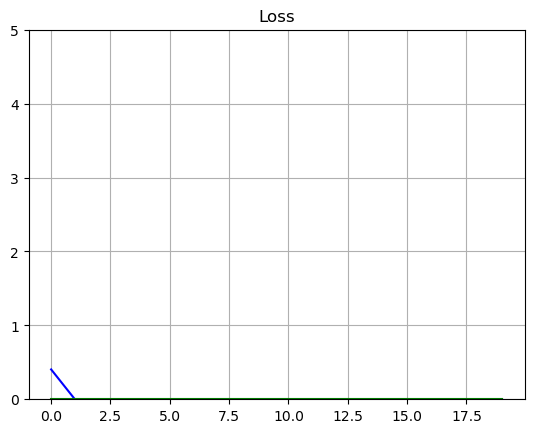

In [20]:
plot_metrics(metric_name='loss', title="Loss")

In [21]:
def create_pairs(data):
    pairs_data = []
    pairs_labels = []
    # go per each of cloth class
    for key in data:
        key_lenght = len(data[key])
        keys_list = list(data.keys())
        for i in range(key_lenght -1):
            # get the positive pair - n and n+1 item from current label
            idx1, idx2 = data[key][i], data[key][i + 1]
            # save to list and set label to 1
            pairs_data.append([get_image_array(idx1), get_image_array(idx2)])
            pairs_labels.append(1.0)
            keys_list.remove(key)
            # add increment to class index and apply modulo by class count to get random negative class label index
            negative_label_index = random.choice(keys_list)
            # take random item from other label items to create a negative pair
            negative_sample = random.choice(data[negative_label_index])
            # save negative pair and set label to 0
            pairs_data.append([get_image_array(idx1), get_image_array(negative_sample)])
            pairs_labels.append(0.0)
    # numpy arrays are easier to work with, so type list into it
    return np.array(pairs_data), np.array(pairs_labels)
        


In [22]:
X_test, Y_test = create_pairs(test_list)


In [23]:
left_pair = X_test[:,0]
left_pair_pred = embedding.predict(left_pair)

1/1 [==============================] - 2s 2s/step


In [24]:
right_pair = X_test[:,1]
right_pair_pred = embedding.predict(right_pair)

1/1 [==============================] - 0s 353ms/step


In [25]:
positive_left_pred = left_pair_pred[0::2]
positive_right_pred = right_pair_pred[0::2]
positive_distances = np.linalg.norm(positive_left_pred - positive_right_pred, axis=1)

In [26]:
pd.Series(positive_distances).describe()

count     1.00000
mean     10.14923
std           NaN
min      10.14923
25%      10.14923
50%      10.14923
75%      10.14923
max      10.14923
dtype: float64

In [27]:
negative_left_pred = left_pair_pred[1::2]
negative_right_pred = right_pair_pred[1::2]
negative_distances = np.linalg.norm(negative_left_pred - negative_right_pred, axis=1)

In [28]:
pd.Series(negative_distances).describe()

count     1.000000
mean     12.184362
std            NaN
min      12.184362
25%      12.184362
50%      12.184362
75%      12.184362
max      12.184362
dtype: float64

In [29]:
border = abs(np.mean(pd.Series(positive_distances)) + np.mean(pd.Series(negative_distances)))/2
print(border)

11.166796207427979


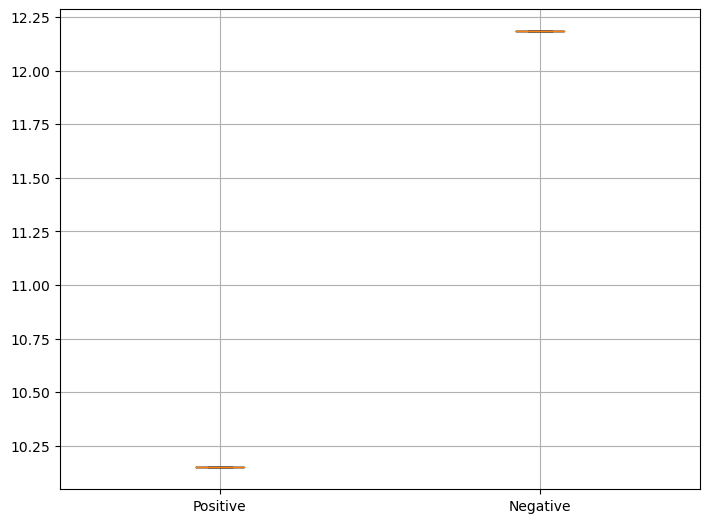

In [30]:
fig = plt.figure()
ax = fig.add_axes([0,0,1, 1])
ax.boxplot([positive_distances, negative_distances])
plt.xticks([1, 2], ['Positive', 'Negative'])
ax.grid()
plt.show()

In [31]:
def compute_accuracy(left_pred, right_pred, y_true):
    y_pred = np.linalg.norm(left_pair_pred - right_pair_pred, axis=1)
#     # 1 for the same - distance is smaller than 3.0, 0 for the different
    pred = y_pred < border
    return np.mean(pred == y_true)

In [32]:
test_accuracy = compute_accuracy(embedding.predict(X_test[:,0]), embedding.predict(X_test[:,1]), Y_test)
print(f'Test accuracy: {test_accuracy*100:.2f}%')

1/1 [==============================] - 0s 336ms/step
Test accuracy: 100.00%
